In [33]:
import pandas as pd
import csv
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt

In [34]:
data = pd.read_csv("Root_Insurance_data.csv",delimiter = ",")
data_click_proba = pd.read_csv("data_click_probability.csv",delimiter = ",")

In [35]:
## Input: Data Frame (in the format of "Root_Insurance_data.csv") and encode_rank (default = False)
## Output: Data Frame (processed by one hot encoding ready to be used to make models)

## This function will one hot encode the following columns in the data frame: 
## Currently Insured, Marital Status, click, rank (optional, determined by encode_rank = True)
## and will drop the respective columns associated to the respective values of above columns:
## unknown, S, False, 5.0 (if encode_rank = True)

import category_encoders as ce

def prepare_data(data:pd.DataFrame(), encode_rank = False, click_proba = False) -> pd.DataFrame():
    temp = data.copy()
    
    if not click_proba:
        if encode_rank:
            one_hot_cols = ["Currently Insured", "Marital Status", "click", "rank"]
            drop_cols = ["Currently Insured_unknown", "Marital Status_S", "rank_5.0", "click_False"]
            column_names = ['Currently Insured_Y', 'Currently Insured_N', 'Number of Vehicles',
                            'Number of Drivers', 'Marital Status_M', 'bid', 'rank_1.0',
                            'rank_2.0', 'rank_3.0', 'rank_4.0', 'click_True', 'policies_sold']
        else:
            one_hot_cols = ["Currently Insured", "Marital Status", "click"]
            drop_cols = ["Currently Insured_unknown", "Marital Status_S", "click_False"]
            column_names = ['Currently Insured_Y', 'Currently Insured_N', 'Number of Vehicles','Number of Drivers',
                            'Marital Status_M', 'bid', 'rank', 'click_True', 'policies_sold']
    else:
        if encode_rank:
            one_hot_cols = ["Currently Insured", "Marital Status", "rank"]
            drop_cols = ["Currently Insured_unknown", "Marital Status_S", "rank_5.0"]
            column_names = ['Currently Insured_Y', 'Currently Insured_N', 'Number of Vehicles',
                            'Number of Drivers', 'Marital Status_M', 'bid', 'rank_1.0',
                            'rank_2.0', 'rank_3.0', 'rank_4.0', 'click', 'policies_sold']
        else:
            one_hot_cols = ["Currently Insured", "Marital Status"]
            drop_cols = ["Currently Insured_unknown", "Marital Status_S"]
            column_names = ['Currently Insured_Y', 'Currently Insured_N', 'Number of Vehicles','Number of Drivers',
                            'Marital Status_M', 'bid', 'rank', 'click', 'policies_sold']
    
    encoder = ce.OneHotEncoder(cols = one_hot_cols, use_cat_names = True)
    temp = encoder.fit_transform(temp)
    temp = temp.drop(columns = drop_cols)
    temp = temp.reindex(columns=column_names)
    return temp

In [36]:
#df = prepare_data(data, click_proba = False)


df = prepare_data(data_click_proba, click_proba = True)

C:\Users\David\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [37]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_curve, accuracy_score

features = ['Currently Insured_Y',
            'Currently Insured_N',
            'Number of Vehicles',
            'Number of Drivers',
            'Marital Status_M',
            'bid',
            'rank',
            'click']
predictor_var = "policies_sold"

df_train, df_test = train_test_split(df,
                                     shuffle=True,
                                     random_state=12345,
                                     test_size=.2,
                                     stratify=df[predictor_var])

In [38]:
## Allows for variantion of resampling with condition resampling = "None", "Up", "Down" or "Balanced"

from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample,shuffle

c_values = [.03, .1, .3, 1, 3, 10, 30, 100]

def obtain_log_scores(data:pd.DataFrame(), num_of_splits = 5, resampling = "None") -> []:
    avg_precision_cross_val = np.zeros((num_of_splits,len(c_values)))
    roc_auc_cross_val = np.zeros((num_of_splits,len(c_values))) 
    accuracy_cross_val = np.zeros((num_of_splits,len(c_values)))  

    kfold = StratifiedKFold(n_splits=num_of_splits, shuffle=True, random_state=77)
    
    i = 0
    for train_index, test_index in kfold.split(df_train[features], df_train[predictor_var]):
        df_train_train = resample_data(data.iloc[train_index], resample_type = resampling)
        df_train_val = data.iloc[test_index]
        
        j = 0
        for c in c_values:
            log_reg = LogisticRegression(C=c)
            log_reg.fit(df_train_train[features], 
                        np.array(df_train_train[predictor_var]).ravel())

            avg_precision_cross_val[i,j] = average_precision_score(df_train_val[predictor_var], 
                                                                 log_reg.predict_proba(df_train_val[features])[:,1])
            roc_auc_cross_val[i,j] = roc_auc_score(df_train_val[predictor_var], 
                                                 log_reg.predict_proba(df_train_val[features])[:,1])
            accuracy_cross_val[i,j] = accuracy_score(df_train_val[predictor_var], 
                                                   log_reg.predict(df_train_val[features]))
            j += 1
        i += 1
    
    return [avg_precision_cross_val, roc_auc_cross_val, accuracy_cross_val]

def resample_data(df:pd.DataFrame(), resample_type = "None") -> pd.DataFrame():
    df_minority = df[df[predictor_var] == 1]
    df_majority = df[df[predictor_var] != 1]
    if resample_type == "Up":
        df_minority_up = resample(df_minority,
                                  random_state=886,
                                  n_samples=len(df_majority),
                                  replace=True)
        df_resampled = pd.concat([df_minority_up, df_majority]).sample(frac=1, random_state = 0)
    elif resample_type == "Down":
        df_majority_down = resample(df_majority,
                                    random_state=886,
                                    n_samples=len(df_minority),
                                    replace=True)
        df_resampled = pd.concat([df_majority_down, df_minority]).sample(frac=1, random_state = 0)
    elif resample_type == "Balanced":
        df_majority_bal = resample(df_majority,
                                           random_state=886,
                                           n_samples= int(len(df)/2),
                                           replace=True)
        df_minority_bal = resample(df_minority,
                                               random_state=886,
                                               n_samples=int(len(df)/2),
                                               replace=True)
        df_resampled = pd.concat([df_majority_bal, df_minority_bal]).sample(frac=1, random_state = 0)  
    else:
        df_resampled = df
    return df_resampled


In [39]:
def plot_charts(avg_precision_avg_val, roc_auc_avg_val, accuracy_avg_val):
    X = [str(x) for x in c_values]
    plt.scatter(X, avg_precision_avg_val, label="AUCPR")
    plt.scatter(X, roc_auc_avg_val, label="AUCROC")
    plt.scatter(X, accuracy_avg_val, label="Accuracy")
    plt.legend()
    plt.xlabel("c value")
    plt.ylabel("avg_cross_val")
    plt.ylim(0,1)
    plt.show()
    print("C value with highest of AUCPR is: " + str(np.argmax(avg_precision_avg_val) + 1))
    print("with AUCPR = " + str(avg_precision_avg_val[np.argmax(avg_precision_avg_val)]))
    print()
    print("C value with highest of AUCROC is: " + str(np.argmax(roc_auc_avg_val) + 1))
    print("with AUCPR = " + str(roc_auc_avg_val[np.argmax(roc_auc_avg_val)]))
    print()
    print("C value with highest of Accuracy is: " + str(np.argmax(accuracy_avg_val) + 1))
    print("with AUCPR = " + str(accuracy_avg_val[np.argmax(accuracy_avg_val)]))

### No Resample Case

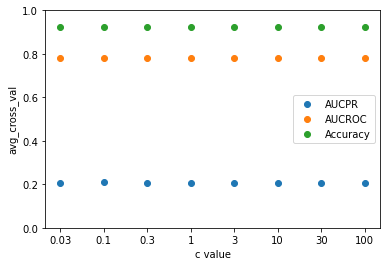

C value with highest of AUCPR is: 2
with AUCPR = 0.20853769847255324

C value with highest of AUCROC is: 2
with AUCPR = 0.7818811566877624

C value with highest of Accuracy is: 1
with AUCPR = 0.92175


In [40]:
avg_precision_cross_val, roc_auc_cross_val, accuracy_cross_val = obtain_log_scores(df_train)
avg_precision_avg_val = np.average(avg_precision_cross_val, axis=0)
roc_auc_avg_val = np.average(roc_auc_cross_val, axis=0)
accuracy_avg_val = np.average(accuracy_cross_val, axis=0)

plot_charts(avg_precision_avg_val, roc_auc_avg_val, accuracy_avg_val)

### Upsample Case

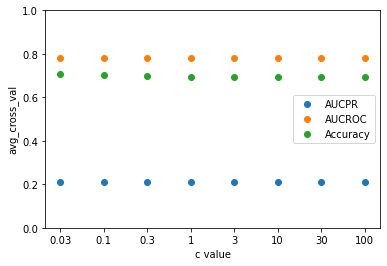

C value with highest of AUCPR is: 1
with AUCPR = 0.2093668454253741

C value with highest of AUCROC is: 1
with AUCPR = 0.7823300418999725

C value with highest of Accuracy is: 1
with AUCPR = 0.7075


In [41]:
avg_precision_cross_val_up, roc_auc_cross_val_up, accuracy_cross_val_up = obtain_log_scores(df_train, resampling = "Up")
avg_precision_avg_val_up = np.average(avg_precision_cross_val_up, axis=0)
roc_auc_avg_val_up = np.average(roc_auc_cross_val_up, axis=0)
accuracy_avg_val_up = np.average(accuracy_cross_val_up, axis=0)

plot_charts(avg_precision_avg_val_up, roc_auc_avg_val_up, accuracy_avg_val_up)

### Downsample Case

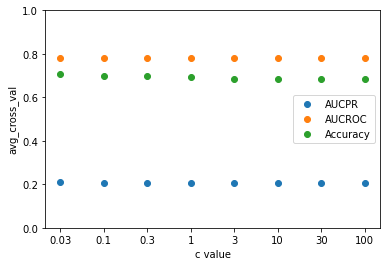

C value with highest of AUCPR is: 1
with AUCPR = 0.20833919674252216

C value with highest of AUCROC is: 1
with AUCPR = 0.7809654683629326

C value with highest of Accuracy is: 1
with AUCPR = 0.706125


In [42]:
avg_precision_cross_val_down, roc_auc_cross_val_down, accuracy_cross_val_down = obtain_log_scores(df_train, resampling = "Down")
avg_precision_avg_val_down = np.average(avg_precision_cross_val_down, axis=0)
roc_auc_avg_val_down = np.average(roc_auc_cross_val_down, axis=0)
accuracy_avg_val_down = np.average(accuracy_cross_val_down, axis=0)

plot_charts(avg_precision_avg_val_down, roc_auc_avg_val_down, accuracy_avg_val_down)

### Balanced Sampling Case

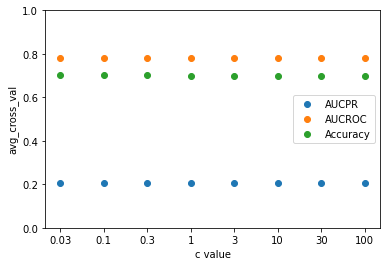

C value with highest of AUCPR is: 4
with AUCPR = 0.20719242809098887

C value with highest of AUCROC is: 2
with AUCPR = 0.7815502251191764

C value with highest of Accuracy is: 1
with AUCPR = 0.704


In [43]:
avg_precision_cross_val_bal, roc_auc_cross_val_bal, accuracy_cross_val_bal = obtain_log_scores(df_train, resampling = "Balanced")
avg_precision_avg_val_bal = np.average(avg_precision_cross_val_bal, axis=0)
roc_auc_avg_val_bal = np.average(roc_auc_cross_val_bal, axis=0)
accuracy_avg_val_bal = np.average(accuracy_cross_val_bal, axis=0)

plot_charts(avg_precision_avg_val_bal, roc_auc_avg_val_bal, accuracy_avg_val_bal)

In [44]:
log_reg = LogisticRegression(C=10)
log_reg.fit(df_train[features], 
            np.array(df_train[predictor_var]).ravel())

LogisticRegression(C=10)

In [45]:
np.unique(log_reg.predict_proba(df_test[features])[:,1], return_counts = True)

(array([0.006253  , 0.0065526 , 0.00765444, 0.00765444, 0.00783238,
        0.00800225, 0.00800225, 0.00820509, 0.00921645, 0.00959496,
        0.00965859, 0.01005158, 0.01126553, 0.01154073, 0.01170853,
        0.01177974, 0.01209052, 0.01411064, 0.01411064, 0.01414842,
        0.01414842, 0.01479071, 0.01479546, 0.01718803, 0.01732981,
        0.01760809, 0.01801194, 0.01802998, 0.01839541, 0.02085466,
        0.02100609, 0.0215581 , 0.0215581 , 0.02157614, 0.02157614,
        0.02180401, 0.02180401, 0.02181955, 0.02252207, 0.02545853,
        0.02593541, 0.02635099, 0.02635099, 0.02649085, 0.02682752,
        0.02682752, 0.02709772, 0.02709772, 0.02737412, 0.02802849,
        0.03057289, 0.03057289, 0.03081727, 0.03168233, 0.03168233,
        0.03181648, 0.03181648, 0.03202438, 0.03309878, 0.03741027,
        0.03758675, 0.03855376, 0.0387659 , 0.03907391, 0.04006277,
        0.04503638, 0.04504801, 0.04504802, 0.04594469, 0.04633037,
        0.04633037, 0.04655029, 0.04687324, 0.04

In [46]:
log_reg = LogisticRegression(C=1)
log_reg.fit(df[features], 
            np.array(df[predictor_var]).ravel())

data_clicks_proba = data_click_proba.copy()
data_clicks_proba["policies_sold"] = log_reg.predict_proba(df[features])[:,1]
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
unique_data_clicks_proba = data_clicks_proba.drop_duplicates(subset = ["Currently Insured",
                                                                       "Number of Vehicles",
                                                                       "Number of Drivers",
                                                                       "Marital Status", 
                                                                       "rank"])
unique_data_clicks_proba.sort_values(by=['policies_sold'], ascending = False)

,Currently Insured,Number of Vehicles,Number of Drivers,Marital Status,bid,rank,click,policies_sold
156,unknown,1,1,S,10,1,0.551078,0.287445
113,unknown,1,1,M,10,1,0.484156,0.272236
40,unknown,1,2,S,10,1,0.563117,0.246623
44,unknown,2,1,S,10,1,0.548264,0.240668
347,N,1,2,S,10,1,0.541124,0.234188
9,unknown,1,2,M,10,1,0.499368,0.232599
102,unknown,2,1,M,10,1,0.513934,0.224440
142,N,1,2,M,10,1,0.499666,0.218849
183,Y,1,1,S,10,1,0.571192,0.215883
34,unknown,2,2,S,10,1,0.524202,0.207385
